In [13]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, Input, concatenate
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt   

In [14]:
data = pd.read_csv("reconstructed_data.csv")

In [15]:
data.head()

,faultNumber,faultOccurrence,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0,-0.314521,0.206706,0.467935,-0.372161,-0.349452,0.109471,-0.243620,0.070797,...,0.066645,-0.407287,-0.173219,-0.090774,0.019754,-0.980940,-0.895641,-0.186526,-0.025459,-0.707759
1,0,0,-0.039404,0.227486,-0.500002,-0.061173,-0.689881,0.458065,-0.211886,-0.696106,...,-0.021992,-0.310417,-0.224462,-0.069100,-0.118322,-1.302023,0.410276,-0.156195,-0.186736,-0.393821
2,0,0,-0.068199,-0.272427,-0.105503,-0.502392,-0.393098,0.164346,-0.239036,0.413166,...,-0.081105,-0.280246,-0.346259,-0.002190,-0.088051,0.103118,1.136940,-0.188147,-0.038354,-0.029488
3,0,0,0.392222,0.085363,0.490939,-0.200437,0.460008,0.868804,-0.188250,0.542744,...,-0.073580,-0.077924,-0.333595,-0.105948,-0.038011,1.278877,1.466087,-0.209400,0.006617,0.099217
4,0,0,-0.265491,-0.320547,-0.222785,-0.321670,-0.785139,-0.601376,-0.207135,0.597304,...,-0.287943,-0.330701,-0.209175,-0.087935,0.048394,0.068811,0.676301,-0.180381,-0.124341,-0.074559


In [41]:
# Define columns to remove
#cols_to_remove = [f'xmeas_{i}' for i in range(23, 42)]
cols_to_remove = []

# Subsample the first 1% of the data and remove specified columns
subsample_size = int(0.01 * len(data))
subsampled_data = data.head(subsample_size).drop(columns=cols_to_remove)

# Split the subsampled data into features (X) and labels (y)
X = subsampled_data.drop(columns=['faultOccurrence', 'faultNumber'])
y = subsampled_data['faultOccurrence']

# Split the subsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [42]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define your autoencoder model architecture
input_dim = X_train_scaled.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=False, validation_data=(X_test_scaled, X_test_scaled), verbose=0)

# Extract encoded representations from the autoencoder
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Define your ANN model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(encoding_dim,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Assuming binary classification for fault occurrence
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the ANN
history = model.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_data=(X_test_encoded, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_encoded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

592/592 [==============================] - 0s 403us/step
Epoch 1/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.3513 - accuracy: 0.8269 - val_loss: 0.1095 - val_accuracy: 0.9738
Epoch 2/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1896 - accuracy: 0.9223 - val_loss: 0.0730 - val_accuracy: 0.9771
Epoch 3/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1600 - accuracy: 0.9358 - val_loss: 0.0751 - val_accuracy: 0.9753
Epoch 4/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1420 - accuracy: 0.9439 - val_loss: 0.0526 - val_accuracy: 0.9822
Epoch 5/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1350 - accuracy: 0.9464 - val_loss: 0.0614 - val_accuracy: 0.9776
Epoch 6/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1285 - accuracy: 0.9489 - val_loss: 0.0749 - val_accuracy: 0.9703
Epoch 7/50
2365/2365 [==============================] - 4s 2ms/step - loss: 0.1

592/592 [==============================] - 0s 640us/step


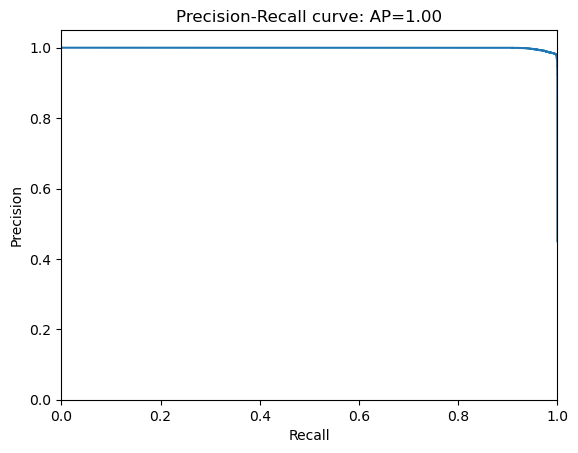

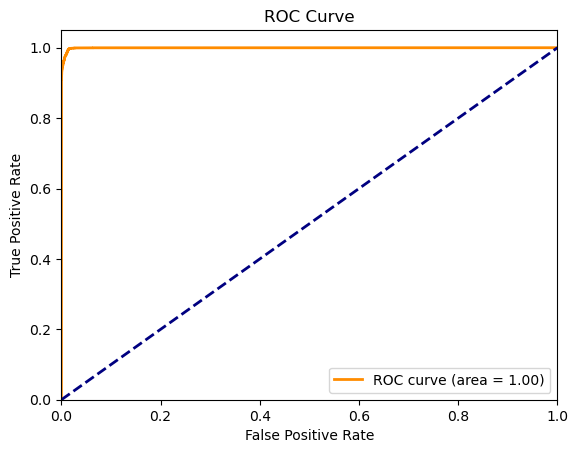

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

# Prepare the test data (assuming X_test and y_test are already prepared)
X_test_scaled = scaler.transform(X_test)  # Scale the test features

# Extract encoded representations from the autoencoder for test data
X_test_encoded = encoder_model.predict(X_test_scaled)

# Predict fault occurrences using the trained ANN
y_pred = model.predict(X_test_encoded)
y_pred_classes = np.round(y_pred).flatten()  # Convert probabilities to binary predictions

# Compute precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

# Compute time-dependent ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot time-dependent ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Additional temporal metrics can be computed and plotted as needed


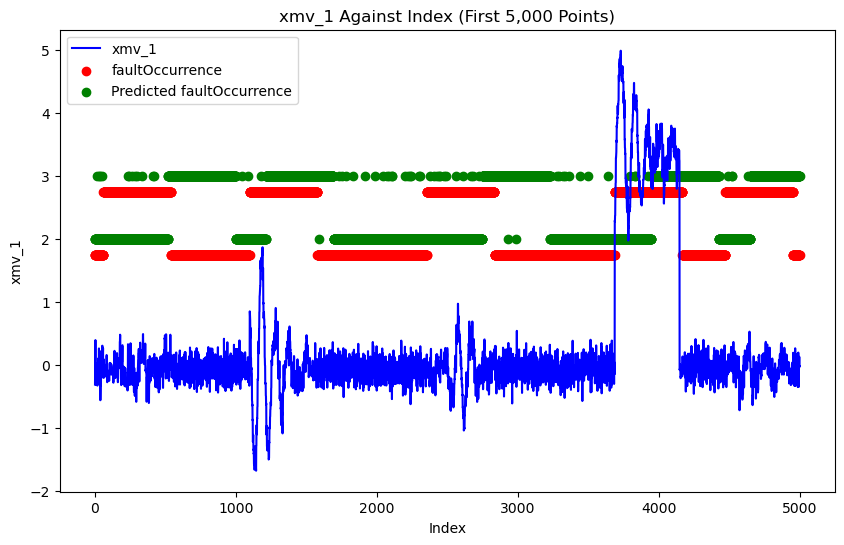

In [46]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing 'xmv_1' and 'faultOccurrence'
xmv_1_values = data['xmeas_1'].values[:5000]  # Slicing to get only the first 5,000 points
fault_occurrence_values = data['faultOccurrence'].values[:5000]

# Assuming 'y_pred_classes' contains the predicted values for faultOccurence
y_pred_classes = y_pred_classes[:5000]  # Slicing to get only the first 5,000 points

# Calculate the offset for the predicted values
offset = 2  # Adjust this value as needed
offset2 = 1.75
y_pred_classes_offset = y_pred_classes + offset
fault_occurrence_values_offset = fault_occurrence_values + offset2

# Plot xmv_1 against index
plt.figure(figsize=(10, 6))
plt.plot(xmv_1_values, color='blue', label='xmv_1')
plt.xlabel('Index')
plt.ylabel('xmv_1')
plt.title('xmv_1 Against Index (First 5,000 Points)')

# Overlay faultOccurrence and predicted_fault_occurrence on the plot
plt.scatter(range(len(fault_occurrence_values_offset)), fault_occurrence_values_offset, color='red', label='faultOccurrence')
plt.scatter(range(len(y_pred_classes_offset)), y_pred_classes_offset, color='green', label='Predicted faultOccurrence')
plt.legend()

plt.show()
